In [298]:
import requests 
import json
import os
from dotenv import load_dotenv
import pandas as pd
from pandas import json_normalize
from bs4 import BeautifulSoup as bs
import time
import seaborn as sns
import matplotlib.pyplot as plt

# Are colder countries more susceptible to Covid-19?

We are going to list our countries by latitude and obtain their average temperature doing web scrapping. Then, we will plot by country and by latitude to see the results

## Function:Get cases in each country ordered by the average latitude of the country

In [336]:
covid_data = pd.DataFrame(pd.read_csv('../data/covid_19_clean_complete.csv')).groupby('Country/Region').mean()
covid_data.sort_values(by='Lat', axis=0, inplace = True,)
covid_data.drop(['Confirmed','Deaths','Recovered','Active'], axis=1, inplace=True)
covid_data.reset_index(inplace=True)
covid_data.rename(columns ={'Country/Region':'country'},inplace=True)
covid_data


,country,Lat,Long
0,New Zealand,-40.900600,174.886000
1,Argentina,-38.416100,-63.616700
2,Chile,-35.675100,-71.543000
3,Uruguay,-32.522800,-55.765800
4,Australia,-32.106275,141.355488
...,...,...,...
182,Norway,60.472000,8.468900
183,Russia,61.524010,105.318756
184,Finland,61.924110,25.748151
185,Iceland,64.963100,-19.020800


In [337]:
covid_data2 = pd.DataFrame(pd.read_csv('../data/covid_19_clean_complete.csv')).groupby('Country/Region').sum()
covid_data2.reset_index(inplace=True)
covid_data2.drop(['Lat','Long'], axis=1, inplace=True)
covid_data2.rename(columns ={'Country/Region':'country'},inplace=True)
covid_data2

,country,Confirmed,Deaths,Recovered,Active
0,Afghanistan,1936390,49098,798240,1089052
1,Albania,196702,5708,118877,72117
2,Algeria,1179755,77972,755897,345886
3,Andorra,94404,5423,69074,19907
4,Angola,22662,1078,6573,15011
...,...,...,...,...,...
182,West Bank and Gaza,233461,1370,61124,170967
183,Western Sahara,901,63,648,190
184,Yemen,67180,17707,23779,25694
185,Zambia,129421,2643,83611,43167


In [339]:
covid_data = pd.merge(covid_data, covid_data2, on='country')

In [341]:
covid_data.sample(5)

,country,Lat,Long,Confirmed,Deaths,Recovered,Active
64,Cambodia,11.550000,104.916700,17079,0,13917,3162
133,Japan,36.204824,138.252924,1952495,85559,1307911,559025
166,Kazakhstan,48.019600,66.923700,2430707,14621,1342402,1073684
44,Colombia,4.570900,-74.297300,6893122,236525,2823811,3832786
16,Bolivia,-16.290200,-63.588700,2170351,78032,571653,1520666


## Function: get average temperature by country by using web scrapping

In [342]:
url = "https://en.wikipedia.org/wiki/List_of_countries_by_average_yearly_temperature"
html = requests.get(url)
soup = bs(html.content,"html.parser")

In [343]:
tabla_temps=soup.findAll("table")[0]


In [344]:
tabla_temps.findAll('tr') [1].findAll('td')[0].getText().strip()

'Burkina Faso'

In [345]:
tabla_temps.findAll('tr')[1].findAll('td')[1].getText().strip()

'28.29'

In [274]:
def averagetemp(x):
    temperature=[]
    for f in x.findAll('tr')[1:]: #list with all rows in the table
        country = f.findAll('td')[0].getText().strip()
        temp = f.findAll('td')[1].getText().strip()

        diccionario = {"country": country, "temp": temp}

        temperature.append(diccionario)
    avTemp = pd.DataFrame(temperature)
    return avTemp

In [346]:
temperature=[]
for f in tabla_temps.findAll('tr')[1:]: #list with all rows in the table
    country = f.findAll('td')[0].getText().strip()
    temp = f.findAll('td')[1].getText().strip()
    
    diccionario = {"country": country, "temp": temp}
    
    temperature.append(diccionario)
avTemp = pd.DataFrame(temperature)

In [275]:
avTemp = averagetemp(tabla_temps)
avTemp.head()

,country,temp
0,Burkina Faso,28.29
1,Mali,28.25
2,Kiribati,28.20
3,Djibouti,28.00
4,Tuvalu,28.00


## Function: merge both dataframes

In [347]:
hyp1=pd.merge(covid_data, avTemp, on="country")
hyp1['temp'].replace(to_replace='−0.70',value=-0.7, inplace = True)
hyp1['temp'].replace(to_replace='−5.10',value=-5.1, inplace = True)
hyp1['temp'].replace(to_replace='−5.35',value=-5.35, inplace = True)
hyp1['temp'] = hyp1['temp'].astype(float)

In [335]:
def merge(x,y):
    hyp1=pd.merge(x, y, on="country")
    hyp1['temp'].replace(to_replace='−0.70',value=-0.7, inplace = True)
    hyp1['temp'].replace(to_replace='−5.10',value=-5.1, inplace = True)
    hyp1['temp'].replace(to_replace='−5.35',value=-5.35, inplace = True)
    hyp1['temp'] = hyp1['temp'].astype(float)
    
    return hyp1

In [348]:
hyp1

,country,Lat,Long,Confirmed,Deaths,Recovered,Active,temp
0,New Zealand,-40.900600,174.886000,175979,2181,149560,24238,10.55
1,Argentina,-38.416100,-63.616700,4450658,97749,1680024,2672885,14.80
2,Chile,-35.675100,-71.543000,16935654,322480,13292593,3320581,8.45
3,Uruguay,-32.522800,-55.765800,94742,2456,72759,19527,17.55
4,Australia,-32.106275,141.355488,960247,11387,711928,236932,21.65
...,...,...,...,...,...,...,...,...
167,Sweden,60.128161,18.643501,4973160,448913,0,4524247,2.10
168,Norway,60.472000,8.468900,1008821,25664,544430,438727,1.50
169,Russia,61.524010,105.318756,45408411,619385,25120448,19668578,-5.10
170,Finland,61.924110,25.748151,713167,30338,544492,138337,1.70


## Function: print results

In [349]:

sns.set_context("poster")
sns.set(rc={"figure.figsize": (12.,8.)})
sns.set_style("whitegrid")

In [350]:
type(hyp1['temp'][4])

numpy.float64

<AxesSubplot:xlabel='Lat', ylabel='temp'>

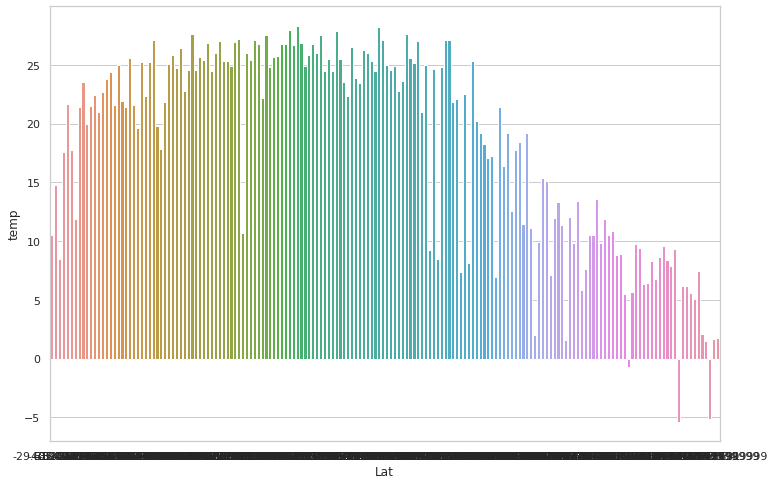

In [351]:
sns.barplot(x='Lat', y = 'temp', data=hyp1);

## Function: generate new column for Zone 

In [352]:
Zones = []
for l in range(0,len(hyp1['Lat'])):
    if hyp1['Lat'][l] < -66.5:
        Zones.append('Antarctic')
    elif hyp1['Lat'][l] < -23.55:
        Zones.append('South Temperate')
    elif hyp1['Lat'][l] < 0:
        Zones.append('South Tropic')
    elif hyp1['Lat'][l] < 23.55:
        Zones.append('North Tropic')
    elif hyp1['Lat'][l] < 66.5:
        Zones.append('North Temperate')
    else:
        Zones.append('Artic')

hyp1['Zones'] = Zones

In [ ]:
hyp1['Zones'] = newzones(hyp1['Lat'])

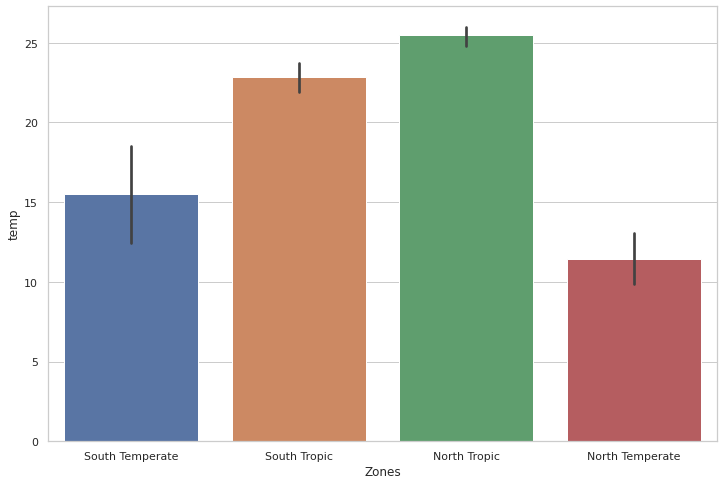

In [353]:
sns.barplot(x='Zones', y = 'temp', data=hyp1);

### The 'Confirmed' column does not provide accurate data, because there is a direct relation between tests done and  confirmed cases. Thus, we need the percentage of people tested that have had a positive result. 

### For this, we are going to call an API

In [206]:
import requests

url = "https://covid-193.p.rapidapi.com/history"

querystring = {"country":'Spain',"day":"2020-11-08"} #Database values are from a year ago

headers = {
    'x-rapidapi-host': "covid-193.p.rapidapi.com",
    'x-rapidapi-key': "c626d6c478msh5f1aa9758ec0e22p1e219ajsn0ed4c7e9c605"
    }

response = requests.request("GET", url, headers=headers, params=querystring).json()


In [203]:
response['response'][0]['tests']['total']

18072174

In [133]:
response['response'][0]['population']

46761136

In [355]:
def poptest(x):
    time.sleep(1.1)
    url = "https://covid-193.p.rapidapi.com/history"

    querystring = {f"country":{x},"day":"2020-11-08"} #Database values are from a year ago

    headers = {
        'x-rapidapi-host': "covid-193.p.rapidapi.com",
        'x-rapidapi-key': "c626d6c478msh5f1aa9758ec0e22p1e219ajsn0ed4c7e9c605"
        }

    response = requests.request("GET", url, headers=headers, params=querystring).json()
    
    try:
        return (response['response'][0]['population'],response['response'][0]['tests']['total'])
        
    except:
        return ('NaN', 'NaN')
    

In [356]:
poputests = hyp1['country'].apply(poptest)

In [357]:
lista=list(poputests)

In [358]:
lista=pd.DataFrame(lista, columns=['Population','Tests'])

In [359]:
hyp1['Population']=lista['Population']
hyp1['Tests']=lista['Tests']

In [360]:
hyp1['Population'] = hyp1['Population'].astype(float)
hyp1['Tests'] = hyp1['Tests'].astype(float)
hyp1['Confirmed'] = hyp1['Confirmed'].astype(float)
hyp1['Deaths'] = hyp1['Deaths'].astype(float)
hyp1['Recovered'] = hyp1['Recovered'].astype(float)
hyp1['Active'] = hyp1['Active'].astype(float)

In [361]:
hyp1['PositiveRate']=hyp1['Confirmed']/hyp1['Tests']

In [362]:
hyp1['Mortality']=hyp1['Deaths']/hyp1['Confirmed']

## Now we can start visualization 

In [363]:
hyp1zones=hyp1.groupby('Zones').mean()

In [364]:
hyp1zones.reset_index(inplace=True)

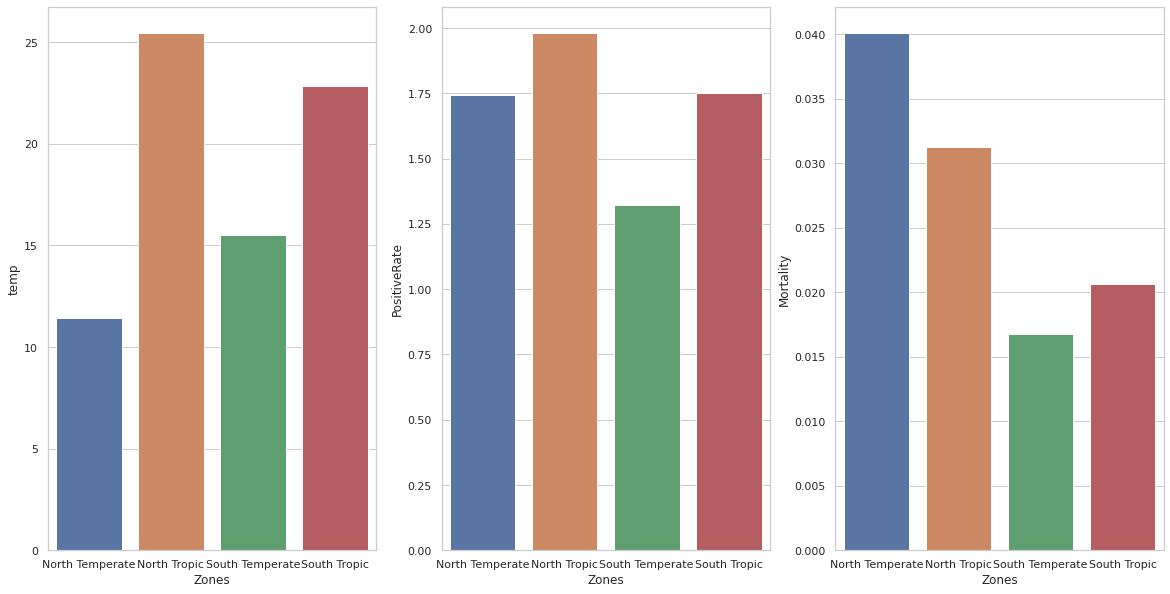

In [376]:

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,10))
sns.barplot(x='Zones', y = 'PositiveRate', data=hyp1zones, ax=axs[1]);
sns.barplot(x='Zones', y = 'temp', data=hyp1zones, ax=axs[0]);
sns.barplot(x='Zones', y = 'Mortality', data=hyp1zones, ax=axs[2]);
fig.savefig('../data/covid_effect_zones.jpg')

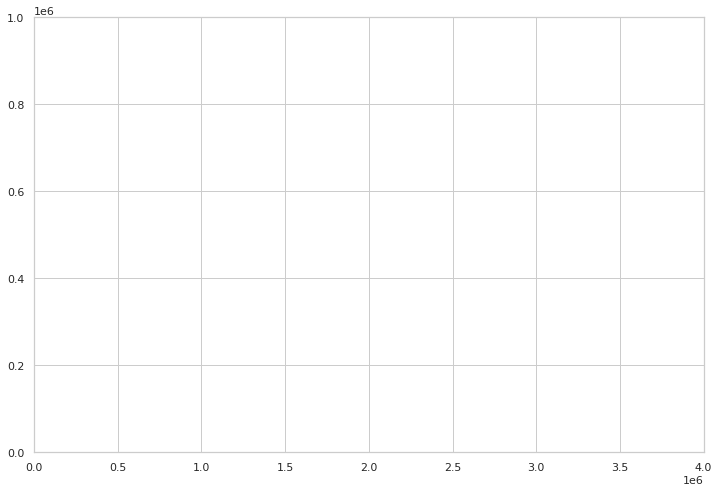

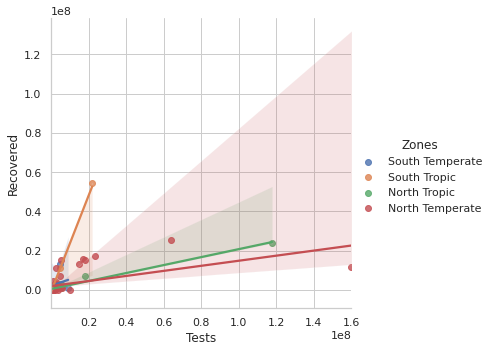

In [377]:
fig, ax = plt.subplots()
sns.lmplot(x='Tests',y='Recovered', hue='Zones', data=hyp1)
ax.set_xlim(0, 4000000)
ax.set_ylim(0,1000000)
plt.show()
fig.savefig('../data/recovered_rate.jpg')